## **Differential Transformer**
This is a lightweight (Differential nanoGPT) implementation of the newly proposed "Differential Tranformer". You can find offical implementation here: https://github.com/microsoft/unilm/tree/master/Diff-Transformer


<img src="assets/dtm.png"/>
<img src="assets/intro.png"/>


Using device: cpu
Loaded Data: (1115394 characters, vocab size 65)
Training Model: LN (LayerNorm)
Trainable Parameters: 0.81 M
Max iterations: 1000
step: 1/1000, loss: 4.1724, mfu: 1.69%
step: 2/1000, loss: 3.9389, mfu: 14.07%
step: 3/1000, loss: 3.7975, mfu: 14.03%
step: 4/1000, loss: 3.7068, mfu: 16.04%
step: 5/1000, loss: 3.6716, mfu: 15.27%
step: 6/1000, loss: 3.6935, mfu: 14.60%
step: 7/1000, loss: 3.5924, mfu: 15.75%
step: 8/1000, loss: 3.6379, mfu: 14.86%
step: 9/1000, loss: 3.6059, mfu: 5.23%
step: 10/1000, loss: 3.5219, mfu: 10.88%
step: 11/1000, loss: 3.5591, mfu: 11.43%
step: 12/1000, loss: 3.5125, mfu: 15.09%
step: 13/1000, loss: 3.4179, mfu: 15.75%
step: 14/1000, loss: 3.4250, mfu: 14.65%
step: 15/1000, loss: 3.3816, mfu: 16.03%
step: 16/1000, loss: 3.3731, mfu: 14.68%
step: 17/1000, loss: 3.3305, mfu: 14.74%
step: 18/1000, loss: 3.2871, mfu: 15.21%
step: 19/1000, loss: 3.2628, mfu: 14.92%
step: 20/1000, loss: 3.2671, mfu: 14.20%
step: 21/1000, loss: 3.1987, mfu: 13.75%
st

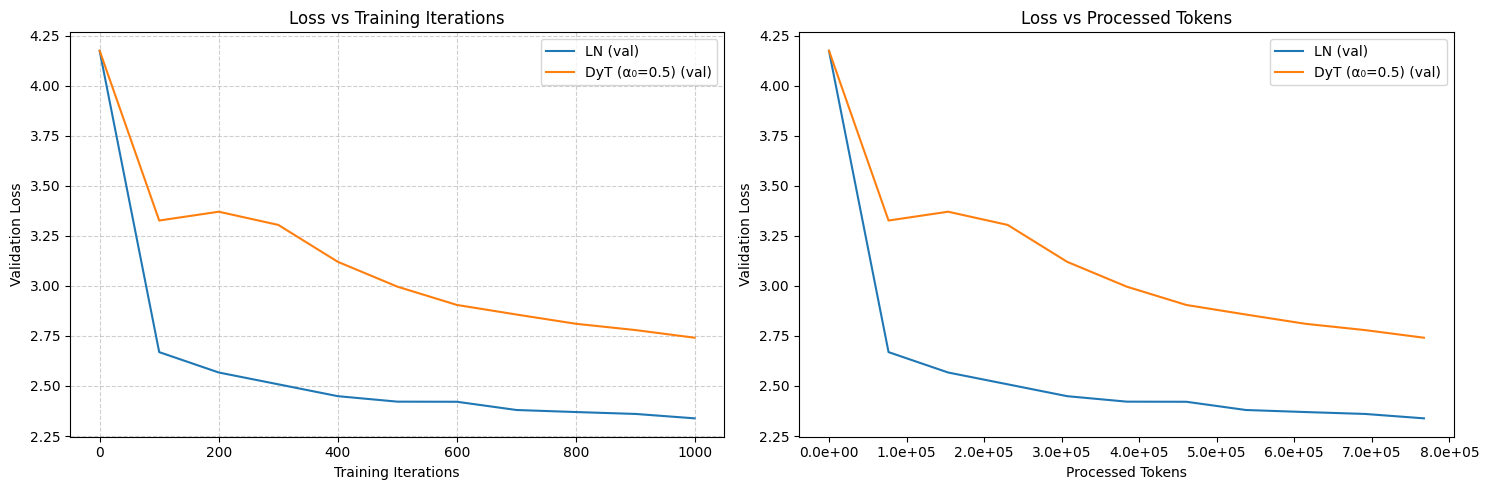


Script finished.


In [11]:
import os
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import warnings

# --- Suppress specific NumPy DeprecationWarning ---
warnings.filterwarnings("ignore", category=DeprecationWarning, module='numpy')
# ---

# Hyperparameters
batch_size = 12
block_size = 64
max_iters = 1000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.2
init_alpha_dyt = 0.5

print(f"Using device: {device}")
if device == 'cuda':
    try:
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    except Exception as e:
        print(f"Could not get CUDA device name: {e}")

# Load and preprocess data (tiny shakespeare)
try:
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    print(f"Loaded Data: ({len(text)} characters, vocab size {len(set(text))})")
except FileNotFoundError:
    print("Error: input.txt not found. Please ensure the file exists in the script directory.")
    exit()
except Exception as e:
    print(f"Error reading input.txt: {e}")
    exit()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

if len(train_data) <= block_size or len(val_data) <= block_size:
    print(f"Warning: Dataset might be too small for block_size={block_size}. Train size: {len(train_data)}, Val size: {len(val_data)}")

def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    if len(data_split) <= block_size:
         raise ValueError(f"Data split '{split}' (length {len(data_split)}) is too small for block_size {block_size}.")

    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i + block_size] for i in ix])
    y = torch.stack([data_split[i + 1:i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)

# Dynamic Tanh Layer
class DynamicTanh(nn.Module):
    """Implements DyT(x) = gamma * tanh(alpha * x) + beta"""
    def __init__(self, dim, init_alpha=0.5):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1, device=device) * init_alpha)
        self.gamma = nn.Parameter(torch.ones(dim, device=device))
        self.beta = nn.Parameter(torch.zeros(dim, device=device))

    def forward(self, x):
        scaled_x = self.alpha * x
        tanh_x = torch.tanh(scaled_x)
        return self.gamma * tanh_x + self.beta

# FeedForward Network
class MLP(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

# Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.n_embd = n_embd
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size))
                             .view(1, 1, block_size, block_size))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

# Transformer Block
class Block(nn.Module):
    def __init__(self, n_embd, n_head, norm_class, init_alpha=0.5):
        super().__init__()
        self.attn = MultiHeadAttention(n_embd, n_head)
        self.mlp = MLP(n_embd)
        if norm_class == DynamicTanh:
            self.norm1 = norm_class(n_embd, init_alpha=init_alpha)
            self.norm2 = norm_class(n_embd, init_alpha=init_alpha)
        elif norm_class == nn.LayerNorm:
             self.norm1 = norm_class(n_embd)
             self.norm2 = norm_class(n_embd)
        else:
             raise ValueError(f"Unsupported norm_class: {norm_class}")

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# nanoGPT Model
class nanoGPT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, norm_class, init_alpha=0.5):
        super().__init__()
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.norm_class_name = norm_class.__name__ # Store norm class name

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, norm_class=norm_class, init_alpha=init_alpha) for _ in range(n_layer)]),
            norm_f = norm_class(n_embd) if norm_class==nn.LayerNorm else norm_class(n_embd, init_alpha=init_alpha)
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

        self.parameter_count = sum(p.numel() for p in self.parameters() if p.requires_grad) / 1e6

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        if t > self.block_size:
           idx = idx[:, :self.block_size]
           t = self.block_size
           if targets is not None:
               targets = targets[:, :self.block_size]

        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.norm_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            if torch.isnan(logits).any():
                print("Warning: NaN detected in logits before loss calculation!")
                return logits, torch.tensor(float('nan'), device=device)
            try:
                loss = F.cross_entropy(
                    logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1
                )
            except Exception as e:
                 print(f"Error calculating cross entropy: {e}")
                 loss = torch.tensor(float('nan'), device=device)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        self.eval()
        for i in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            if torch.isnan(logits).any():
                print(f"Warning: NaN detected in logits during generation step {i+1}. Stopping generation.")
                break
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            if torch.isnan(probs).any():
                 print(f"Warning: NaN detected in probabilities during generation step {i+1}. Stopping generation.")
                 break
            try:
                idx_next = torch.multinomial(probs, num_samples=1)
            except RuntimeError as e:
                print(f"Error during multinomial sampling step {i+1}: {e}")
                print("Probabilities:", probs)
                break
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# MFU Calculation
def compute_mfu(model, dt):
    if not all(hasattr(model, attr) for attr in ['n_layer', 'n_embd', 'block_size']): return 0.0
    N = sum(p.numel() for p in model.parameters() if p.requires_grad)
    L, H, T = model.n_layer, model.n_embd, model.block_size
    flops_per_token = 6 * N + 12 * L * H * T
    global batch_size
    flops_per_fwdbwd = flops_per_token * T * batch_size
    flops_achieved = flops_per_fwdbwd / dt if dt > 0 else 0
    flops_promised = 1e12
    if device == 'cuda':
        try:
            dev_name = torch.cuda.get_device_name(0).upper()
            if 'A100' in dev_name: flops_promised = 312e12
            elif 'H100' in dev_name: flops_promised = 1979e12
            elif 'V100' in dev_name: flops_promised = 125e12
            elif 'TESLA T4' in dev_name or ' T4' in dev_name: flops_promised = 65e12
            elif 'RTX 4090' in dev_name: flops_promised = 82.6e12
            elif 'RTX 3090' in dev_name: flops_promised = 35.6e12
        except Exception: pass
    mfu = flops_achieved / flops_promised if flops_promised > 0 else 0.0
    return mfu

# Eval 
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            try:
                X, Y = get_batch(split)
                _, loss = model(X, Y)
                if torch.isnan(loss): losses[k] = float('nan')
                else: losses[k] = loss.item()
            except ValueError: losses[k] = float('nan')
            except Exception as e:
                print(f"Error during {split} eval k={k}: {e}")
                losses[k] = float('nan')
        out[split] = torch.nanmean(losses) if not torch.all(torch.isnan(losses)) else float('nan')
    model.train()
    return out

# Global dict to store results for plotting
all_results = {
    'LN': {'iters': [], 'val_losses': [], 'tokens': []},
    'DyT': {'iters': [], 'val_losses': [], 'tokens': []}
}

# Training 
def train_model(model, model_type):
    print("=" * (30 + len(model_type) + len(model.norm_class_name)))
    print(f"Training Model: {model_type} ({model.norm_class_name})")
    print(f"Trainable Parameters: {model.parameter_count:.2f} M")
    print(f"Max iterations: {max_iters}")
    print("=" * (30 + len(model_type) + len(model.norm_class_name)))

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95))

    run_iters, run_val_losses, run_tokens = [], [], []
    t_start_training = time.time()
    t0 = time.time()
    nan_loss_streak = 0
    max_nan_streak = 10

    for iter_num in range(max_iters):
        if iter_num == 0 or iter_num % eval_interval == 0 or iter_num == max_iters - 1:
            loss_dict = estimate_loss(model)
            val_loss = loss_dict['val']
            run_iters.append(iter_num)
            run_val_losses.append(val_loss)
            processed_tokens = iter_num * batch_size * block_size
            run_tokens.append(processed_tokens)

        # Training step
        try:
            xb, yb = get_batch('train')
        except ValueError as e:
            print(f"\n{e}. Stopping training for {model_type}.")
            break
        except Exception as e:
            print(f"\nUnexpected error getting batch at iter {iter_num}: {e}. Skipping.")
            continue

        try:
            _, loss = model(xb, yb)
            if torch.isnan(loss):
                print(f"\nWarning: NaN loss detected at training iter {iter_num}. Skipping update.")
                nan_loss_streak += 1
                if nan_loss_streak >= max_nan_streak:
                    print(f"Stopping training for {model_type} due to {max_nan_streak} consecutive NaN losses.")
                    break
                t0 = time.time()
                continue
            else:
                lossf = loss.item()
                nan_loss_streak = 0
        except Exception as e:
             print(f"\nError during forward pass at iter {iter_num}: {e}. Skipping.")
             t0 = time.time()
             continue

        optimizer.zero_grad(set_to_none=True)
        try:
            loss.backward()
        except Exception as e:
             print(f"\nError during backward pass at iter {iter_num}: {e}. Skipping step.")
             t0 = time.time()
             continue

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        try:
            mfu = compute_mfu(model, dt)
            mfu_str = f"{mfu*100:.2f}%"
        except Exception:
            mfu_str = "N/A"
        print(f"step: {iter_num+1}/{max_iters}, loss: {lossf:.4f}, mfu: {mfu_str}") # Use iter_num+1 for 1-based step count

    print(f"\nFinished training {model_type}. Total time: {time.time() - t_start_training:.2f}s")
    all_results[model_type]['iters'].extend(run_iters)
    all_results[model_type]['val_losses'].extend(run_val_losses)
    all_results[model_type]['tokens'].extend(run_tokens)

    checkpoint_dir = 'checkpoints_dyt_compare'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_{model_type}.pt")
    try:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Final model checkpoint saved to {checkpoint_path}")
    except Exception as e:
        print(f"Error saving final checkpoint for {model_type}: {e}")

def init_model(norm_class, init_alpha=None):
    model_args = {'norm_class': norm_class}
    if norm_class == DynamicTanh and init_alpha is not None:
        model_args['init_alpha'] = init_alpha

    try:
        model = nanoGPT(
            vocab_size, n_embd, n_head, n_layer, block_size, **model_args
        ).to(device)
        return model
    except Exception as e:
        print(f"Error initializing {norm_class.__name__} model: {e}")
        exit()

# Init Models
ln_model = init_model(nn.LayerNorm) # with layer normalization
dyt_model = init_model(DynamicTanh, init_alpha=init_alpha_dyt) # with dynamic tanh (no layernorm)

# Train Models
train_model(ln_model, "LN")
train_model(dyt_model, "DyT")

# Plots
def plot_loss_curves(results):
    print("\nGenerating Plots...")
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax = axs[0]
    ln_iters_filt = [it for it, vl in zip(results['LN']['iters'], results['LN']['val_losses']) if not np.isnan(vl)]
    ln_val_filt = [vl for vl in results['LN']['val_losses'] if not np.isnan(vl)]
    if ln_iters_filt:
        ax.plot(ln_iters_filt, ln_val_filt, label='LN (val)', linestyle='-')

    dyt_iters_filt = [it for it, vl in zip(results['DyT']['iters'], results['DyT']['val_losses']) if not np.isnan(vl)]
    dyt_val_filt = [vl for vl in results['DyT']['val_losses'] if not np.isnan(vl)]
    if dyt_iters_filt:
        ax.plot(dyt_iters_filt, dyt_val_filt, label=f'DyT (α₀={init_alpha_dyt}) (val)', linestyle='-')

    ax.set_xlabel('Training Iterations')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Loss vs Training Iterations')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax = axs[1]
    ln_tokens_filt = [tk for tk, vl in zip(results['LN']['tokens'], results['LN']['val_losses']) if not np.isnan(vl)]
    if ln_tokens_filt:
        ax.plot(ln_tokens_filt, ln_val_filt, label='LN (val)', linestyle='-')

    dyt_tokens_filt = [tk for tk, vl in zip(results['DyT']['tokens'], results['DyT']['val_losses']) if not np.isnan(vl)]
    if dyt_tokens_filt:
        ax.plot(dyt_tokens_filt, dyt_val_filt, label=f'DyT (α₀={init_alpha_dyt}) (val)', linestyle='-')

    ax.set_xlabel('Processed Tokens')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Loss vs Processed Tokens')
    ax.legend()
    # ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))

    plt.tight_layout()
    try:
        plt.show()
    except Exception as e:
        print(f"Error displaying plot: {e}")
    plt.close()

if all_results['LN']['iters'] or all_results['DyT']['iters']:
    plot_loss_curves(all_results)
else:
    print("\nSkipping plotting as no training results were generated.")

print("\nScript finished.")